<a href="https://colab.research.google.com/github/mitsuo/juntendo-hds/blob/main/3d_brain_tumor_segmentation_colab_a100_fast_optimized_lowram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain tumor 3D segmentation with MONAI and Weights & Biases

This tutorial shows how to construct a training workflow of multi-labels 3D brain tumor segmentation task using [MONAI](https://github.com/Project-MONAI/MONAI) and use experiment tracking and data visualization features of [Weights & Biases](https://wandb.ai/site). The tutorial contains the following features:

1. Initialize a Weights & Biases run and synchrozize all configs associated with the run for reproducibility.
2. MONAI transform API:
    1. MONAI Transforms for dictionary format data.
    2. How to define a new transform according to MONAI `transforms` API.
    3. How to randomly adjust intensity for data augmentation.
3. Data Loading and Visualization:
    1. Load Nifti image with metadata, load a list of images and stack them.
    2. Cache IO and transforms to accelerate training and validation.
    3. Visualize the data using `wandb.Table` and interactive segmentation overlay on Weights & Biases.
4. Training a 3D `SegResNet` model
    1. Using the `networks`, `losses`, and `metrics` APIs from MONAI.
    2. Training the 3D `SegResNet` model using a PyTorch training loop.
    3. Track the training experiment using Weights & Biases.
    4. Log and version model checkpoints as model artifacts on Weights & Biases.
5. Visualize and compare the predictions on the validation dataset using `wandb.Table` and interactive segmentation overlay on Weights & Biases.

## 🌴 Setup and Installation

First, let us install the latest version of both MONAI and Weights and Biases.

In [1]:
!python -c "import monai" || pip install -q -U "monai[nibabel, tqdm]"
!python -c "import wandb" || pip install -q -U wandb

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 66.4 MB/s eta 0:00:00


In [2]:
import os

import numpy as np
from tqdm.auto import tqdm
import wandb

from monai.apps import DecathlonDataset
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.config import print_config
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    MapTransform,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)
from monai.utils import set_determinism

import torch

print_config()

<frozen importlib._bootstrap_external>:1301: FutureWarning: The cuda.cudart module is deprecated and will be removed in a future release, please switch to use the cuda.bindings.runtime module instead.


MONAI version: 1.5.1
Numpy version: 2.0.2
Pytorch version: 2.9.0+cu126
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 9c6d819f97e37f36c72f3bdfad676b455bd2fa0d
MONAI __file__: /usr/local/lib/python3.12/dist-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.3.3
scikit-image version: 0.25.2
scipy version: 1.16.3
Pillow version: 11.3.0
Tensorboard version: 2.19.0
gdown version: 5.2.0
TorchVision version: 0.24.0+cu126
tqdm version: 4.67.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.2.2
einops version: 0.8.1
transformers version: 4.57.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/la

We will then authenticate this colab instance to use W&B.

In [3]:
wandb.login()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: mitsuo (team-mitsuo) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## 🌳 Initialize a W&B Run

We will start a new W&B run to start tracking our experiment.

In [4]:
wandb.init(project="monai-brain-tumor-segmentation")

Use of proper config system is a recommended best practice for reproducible machine learning. We can track the hyperparameters for every experiment using W&B.

In [5]:
config = wandb.config
config.seed = 0

# === A100 High-Memory Optimized Hyperparameters ===
# Training window size (3D crop): large ROI that still fits comfortably on A100
config.roi_size = [224, 224, 144]

# Larger batch size is OK on A100; increase further (e.g., 4) if VRAM allows
config.batch_size = 2

# DataLoader workers:
# 0 is the most stable in Colab / notebook environments (avoids multiprocessing issues).
# If your environment is stable, you can try 2 or 4 for faster CPU-side loading.
config.num_workers = 4

# Cache part of the dataset in RAM to speed up I/O on high-RAM instances.
# config.cache_rate = 0.1  # 10% of samples cached in RAM to avoid OOM
# 1.0 = cache all; reduce (e.g., 0.25) if system RAM is limited.
config.cache_rate = 1.0

# Visualization limits for W&B (reduce logging overhead a bit)
config.max_train_images_visualized = 5
config.max_val_images_visualized = 5
config.max_prediction_images_visualized = 5

# Dice loss parameters
config.dice_loss_smoothen_numerator = 0
config.dice_loss_smoothen_denominator = 1e-5
config.dice_loss_squared_prediction = True
config.dice_loss_target_onehot = False
config.dice_loss_apply_sigmoid = True

# Optimizer / scheduler
config.initial_learning_rate = 1e-4
config.weight_decay = 1e-5
config.max_train_epochs = 50
config.validation_intervals = 1

# Sliding-window inference params (validation / prediction)
# Large ROI for A100-class GPUs (close to full volume)
config.inference_roi_size = (240, 240, 160)

# Use more sliding-window mini-batch to better utilize A100; adjust if OOM.
config.sw_batch_size = 4
config.sw_overlap = 0.5

# Model size (higher = more capacity, more VRAM)
config.init_filters = 16

# Paths
config.dataset_dir = "./dataset/"
config.checkpoint_dir = "./checkpoints"

# Validation budget per epoch (-1 = use all validation batches)
config.max_val_batches_per_epoch = -1

We would also need to set the random seed for modules to enable or disable deterministic training.

In [6]:
set_determinism(seed=config.seed)

# Create directories
os.makedirs(config.dataset_dir, exist_ok=True)
os.makedirs(config.checkpoint_dir, exist_ok=True)

## 💿 Data Loading and Transformation

Here we use the `monai.transforms` API to create a custom transform that converts the multi-classes labels into multi-labels segmentation task in one-hot format.

In [7]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is the peritumoral edema
    label 2 is the GD-enhancing tumor
    label 3 is the necrotic and non-enhancing tumor core
    The possible classes are TC (Tumor core), WT (Whole tumor)
    and ET (Enhancing tumor).

    Reference: https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/brats_segmentation_3d.ipynb

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # merge label 2 and label 3 to construct TC
            result.append(torch.logical_or(d[key] == 2, d[key] == 3))
            # merge labels 1, 2 and 3 to construct WT
            result.append(
                torch.logical_or(
                    torch.logical_or(d[key] == 2, d[key] == 3), d[key] == 1
                )
            )
            # label 2 is ET
            result.append(d[key] == 2)
            d[key] = torch.stack(result, dim=0).float()
        return d


Next, we set up transforms for training and validation datasets respectively.

In [8]:
train_transform = Compose(
    [
        # load 4 Nifti images and stack them together
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(
            keys=["image", "label"], roi_size=config.roi_size, random_size=False
        ),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
    ]
)
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

/usr/local/lib/python3.12/dist-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.spatial.dictionary Orientationd.__init__:labels: Current default value of argument `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` was changed in version None from `labels=(('L', 'R'), ('P', 'A'), ('I', 'S'))` to `labels=None`. Default value changed to None meaning that the transform now uses the 'space' of a meta-tensor, if applicable, to determine appropriate axis labels.
  warn_deprecated(argname, msg, warning_category)


### 🍁 The Dataset

The dataset that we will use for this experiment comes from http://medicaldecathlon.com/. We will use Multimodal multisite MRI data (FLAIR, T1w, T1gd, T2w) to segment Gliomas, necrotic/active tumour, and oedema. The dataset consists of 750 4D volumes (484 Training + 266 Testing).

We will use the `DecathlonDataset` to automatically download and extract the dataset. It inherits MONAI `CacheDataset` which enables us to set `cache_num=N` to cache `N` items for training and use the default args to cache all the items for validation, depending on your memory size.

In [9]:
from monai.apps import DecathlonDataset

train_dataset = DecathlonDataset(
    root_dir=config.dataset_dir,
    task="Task01_BrainTumour",
    transform=train_transform,
    section="training",
    download=True,
    cache_rate=config.cache_rate,
    num_workers=config.num_workers,
)

val_dataset = DecathlonDataset(
    root_dir=config.dataset_dir,
    task="Task01_BrainTumour",
    transform=val_transform,
    section="validation",
    download=False,
    cache_rate=config.cache_rate,
    num_workers=config.num_workers,
)


Task01_BrainTumour.tar: 7.09GB [05:58, 21.2MB/s]                            

2025-12-13 10:30:58,492 - INFO - Downloaded: dataset/Task01_BrainTumour.tar


2025-12-13 10:31:13,022 - INFO - Verified 'Task01_BrainTumour.tar', md5: 240a19d752f0d9e9101544901065d872.
2025-12-13 10:31:13,024 - INFO - Writing into directory: dataset.


Loading dataset: 100%|██████████| 96/96 [00:44<00:00,  2.17it/s]


**Note:** Instead of applying the `train_transform` to the `train_dataset`, we have applied `val_transform` to both the training and validation datasets. This is because, before training, we would be visualizing samples from both the splits of the dataset.

### 📸 Visualizing the Dataset

Weights & Biases supports images, video, audio, and more. Log rich media to explore our results and visually compare our runs, models, and datasets. We would be using the [segmentation mask overlay system](https://docs.wandb.ai/guides/track/log/media#image-overlays-in-tables) to visualize our data volumes. To log segmentation masks in [tables](https://docs.wandb.ai/guides/tables), we will need to provide a `wandb.Image`` object for each row in the table.

An example is provided in the Code snippet below:

```python
table = wandb.Table(columns=["ID", "Image"])

for id, img, label in zip(ids, images, labels):
    mask_img = wandb.Image(
        img,
        masks={
            "prediction": {"mask_data": label, "class_labels": class_labels}
            # ...
        },
    )

    table.add_data(id, img)

wandb.log({"Table": table})
```

Let us now write a simple utility function that takes a sample image, label, `wandb.Table` object and some associated metadata and populate the rows of a table that would be logged to our Weights & Biases dashboard.

In [10]:
def log_data_samples_into_tables(
    sample_image: np.ndarray,
    sample_label: np.ndarray,
    split: str,
    data_idx: int,
    table=None,
    max_slices: int = 24,
):
    """
    Log a subset of slices into a W&B Table.

    - sample_image: (C, H, W, D)
    - sample_label: (3, H, W, D)
    """
    if sample_image is None or sample_label is None:
        return table

    num_channels, _, _, num_slices = sample_image.shape

    # Create a table on first call
    if table is None:
        channel_names = ["T1", "T1ce", "T2", "FLAIR"] if num_channels == 4 else [f"ch{i}" for i in range(num_channels)]
        columns = ["split", "data_idx", "slice_idx", *channel_names]
        table = wandb.Table(columns=columns)

    # Slice sampling to keep logging lightweight
    if max_slices is None or max_slices <= 0 or max_slices >= num_slices:
        slice_indices = list(range(num_slices))
    else:
        step = max(1, num_slices // max_slices)
        slice_indices = list(range(0, num_slices, step))[:max_slices]

    for slice_idx in slice_indices:
        imgs = []
        for channel_idx in range(num_channels):
            imgs.append(
                wandb.Image(
                    sample_image[channel_idx, :, :, slice_idx],
                    masks={
                        "ground-truth/Tumor-Core": {
                            "mask_data": (sample_label[0, :, :, slice_idx] > 0).astype(np.uint8),
                            "class_labels": {0: "background", 1: "Tumor Core"},
                        },
                        "ground-truth/Whole-Tumor": {
                            "mask_data": (sample_label[1, :, :, slice_idx] > 0).astype(np.uint8) * 2,
                            "class_labels": {0: "background", 2: "Whole Tumor"},
                        },
                        "ground-truth/Enhancing-Tumor": {
                            "mask_data": (sample_label[2, :, :, slice_idx] > 0).astype(np.uint8) * 3,
                            "class_labels": {0: "background", 3: "Enhancing Tumor"},
                        },
                    },
                )
            )
        table.add_data(split, data_idx, slice_idx, *imgs)

    return table


Next, we define the `wandb.Table` object and what columns it consists of so that we can populate with our data visualizations.

In [11]:
table = wandb.Table(
    columns=[
        "Split",
        "Data Index",
        "Slice Index",
        "Image-Channel-0",
        "Image-Channel-1",
        "Image-Channel-2",
        "Image-Channel-3",
    ]
)

Then we loop over the `train_dataset` and `val_dataset` respectively to generate the visualizations for the data samples and populate the rows of the table which we would log to our dashboard.

In [12]:
# Generate visualizations for train_dataset (lightweight)
max_train = (
    min(config.max_train_images_visualized, len(train_dataset))
    if config.max_train_images_visualized > 0
    else len(train_dataset)
)

table = None
progress_bar = tqdm(range(max_train), desc="Generating Train Dataset Visualizations:")
for data_idx in progress_bar:
    sample = train_dataset[data_idx]
    sample_image = sample["image"].detach().cpu().numpy()
    sample_label = sample["label"].detach().cpu().numpy()
    table = log_data_samples_into_tables(
        sample_image,
        sample_label,
        split="train",
        data_idx=data_idx,
        table=table,
        max_slices=24,
    )

# Generate visualizations for val_dataset (lightweight)
max_val = (
    min(config.max_val_images_visualized, len(val_dataset))
    if config.max_val_images_visualized > 0
    else len(val_dataset)
)

progress_bar = tqdm(range(max_val), desc="Generating Validation Dataset Visualizations:")
for data_idx in progress_bar:
    sample = val_dataset[data_idx]
    sample_image = sample["image"].detach().cpu().numpy()
    sample_label = sample["label"].detach().cpu().numpy()
    table = log_data_samples_into_tables(
        sample_image,
        sample_label,
        split="val",
        data_idx=data_idx,
        table=table,
        max_slices=24,
    )

# Log the table to your dashboard (only if table exists)
if table is not None:
    wandb.log({"Tumor-Segmentation-Data": table})


Generating Train Dataset Visualizations::   0%|          | 0/5 [00:00<?, ?it/s]

wandb: WARNING Data passed to `wandb.Image` should consist of values in the range [0, 255], image data will be normalized to this range, but behavior will be removed in a future version of wandb.


Generating Validation Dataset Visualizations::   0%|          | 0/5 [00:00<?, ?it/s]

The data appears to us on our W&B dashboard in an interactive tabular format. We can see each channel of a particular slice from a data volume overlayed with the respective segmentation mask in each row. Let us write [Weave queries](https://docs.wandb.ai/guides/weave) to filter the data on our table and focus on one particular row.

![](https://github.com/wandb/examples/blob/master/colabs/monai/assets/viz-1.gif?raw=1)

Let us now open an image and check how we can interact with each of the segmentation masks using the interactive overlay.

![](https://github.com/wandb/examples/blob/master/colabs/monai/assets/viz-2.gif?raw=1)

**Note:** The labels in the dataset consist of non-overlapping masks across classes, hence, they were logged as separate masks in the overlay.

### 🛫 Loading the Data

We create the PyTorch dataloaders for loading the data from the datasets. Note that before creating the dataloaders, we set the `transform` for `train_dataset` to `train_transform` to preprocess and transform the data for training.

In [13]:
# apply train_transforms to the training dataset
train_dataset.transform = train_transform

# create the train_loader / val_loader
pin = torch.cuda.is_available()

train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=pin,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=pin,
)


## 🤖 Creating the Model, Loss, and Optimizer

In this tutorial we will be training a `SegResNet` model based on the paper [3D MRI brain tumor segmentation using autoencoder regularization](https://arxiv.org/pdf/1810.11654.pdf). We create the `SegResNet` model that comes implemented as a PyTorch Module as part of the `monai.networks` API. We also create our optimizer and learning rate scheduler.

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_amp = device.type == "cuda"

# create model
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=int(getattr(config, "init_filters", 16)),
    in_channels=4,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

optimizer = torch.optim.Adam(
    model.parameters(),
    config.initial_learning_rate,
    weight_decay=config.weight_decay,
)

lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=config.max_train_epochs
)


We define our loss as multi-label `DiceLoss` using the `monai.losses` API and the corresponding dice metrics using the `monai.metrics` API.

In [15]:
loss_function = DiceLoss(
    smooth_nr=config.dice_loss_smoothen_numerator,
    smooth_dr=config.dice_loss_smoothen_denominator,
    squared_pred=config.dice_loss_squared_prediction,
    to_onehot_y=config.dice_loss_target_onehot,
    sigmoid=config.dice_loss_apply_sigmoid,
)

dice_metric = DiceMetric(include_background=True, reduction="mean")
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# Automatic Mixed Precision (CUDA only)
try:
    scaler = torch.amp.GradScaler("cuda", enabled=use_amp)
except Exception:
    scaler = torch.cuda.amp.GradScaler(enabled=use_amp)

if device.type == "cuda":
    torch.backends.cudnn.benchmark = True


In [16]:
def inference(model, inputs):
    """Run sliding-window inference on `inputs` on the same device as `model`.

    This version is optimized for high-memory GPUs (e.g., A100-class GPUs):
    it keeps the full volume and the output on the same device as the model
    when CUDA is available.
    """
    # Use config values if they exist, otherwise reasonable defaults
    roi_size = tuple(getattr(config, "inference_roi_size", (240, 240, 160)))
    sw_batch_size = int(getattr(config, "sw_batch_size", 1))
    overlap = float(getattr(config, "sw_overlap", 0.5))

    # sliding_window_inference will use the device of the input tensors.
    # We assume `inputs` is already moved to the same device as `model`.
    return sliding_window_inference(
        inputs=inputs,
        roi_size=roi_size,
        sw_batch_size=sw_batch_size,
        predictor=model,
        overlap=overlap,
        sw_device=device,
    )


## 🚝 Training and Validation

Before we start training, let us define some metric properties which will later be logged with `wandb.log()` for tracking our training and validation experiments.

In [17]:
wandb.define_metric("epoch/epoch_step")
wandb.define_metric("epoch/*", step_metric="epoch/epoch_step")
wandb.define_metric("batch/batch_step")
wandb.define_metric("batch/*", step_metric="batch/batch_step")
wandb.define_metric("validation/validation_step")
wandb.define_metric("validation/*", step_metric="validation/validation_step")

batch_step = 0
validation_step = 0
metric_values = []
metric_values_tumor_core = []
metric_values_whole_tumor = []
metric_values_enhanced_tumor = []

### 🍭 Execute Standard PyTorch Training Loop

In [18]:
best_metric = -1.0
best_metric_epoch = -1
validation_step = 0

# How many validation batches to run per validation phase (-1 = all)
max_val_batches = int(getattr(config, "max_val_batches_per_epoch", -1))

# Epoch-level progress bar
epoch_progress_bar = tqdm(range(config.max_train_epochs), desc="Training:")

for epoch in epoch_progress_bar:
    model.train()
    epoch_loss = 0.0

    # Batch-level progress bar
    total_batch_steps = max(1, len(train_loader))
    batch_progress_bar = tqdm(train_loader, total=total_batch_steps, leave=False)

    for step, batch_data in enumerate(batch_progress_bar):
        # Move training data to device
        inputs = batch_data["image"].to(device, non_blocking=True)
        labels = batch_data["label"].to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        try:
            # Forward + loss (AMP only on CUDA)
            if device.type == "cuda":
                with torch.amp.autocast("cuda", enabled=use_amp):
                    outputs = model(inputs)
                    loss = loss_function(outputs, labels)
            else:
                outputs = model(inputs)
                loss = loss_function(outputs, labels)

            # Backward
            if use_amp and device.type == "cuda":
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                loss.backward()
                optimizer.step()

        except RuntimeError as e:
            # Handle CUDA OOM gracefully by skipping this batch
            if "out of memory" in str(e).lower():
                print("⚠️ CUDA OOM: skipping this batch and clearing cache.")
                optimizer.zero_grad(set_to_none=True)
                if device.type == "cuda":
                    torch.cuda.empty_cache()
                continue
            # Re-raise any non-OOM error
            raise

        epoch_loss += loss.item()
        batch_progress_bar.set_description(f"train_loss: {loss.item():.4f}")

    # Average loss over the epoch
    epoch_loss /= max(1, total_batch_steps)
    lr_scheduler.step()

    # Log epoch-level metrics
    wandb.log(
        {
            "epoch/epoch": epoch,
            "epoch/train_loss": epoch_loss,
            "epoch/learning_rate": lr_scheduler.get_last_lr()[0],
        }
    )
    epoch_progress_bar.set_description(f"Training: train_loss: {epoch_loss:.4f}:")

    # ===== Validation + checkpointing =====
    if (epoch + 1) % config.validation_intervals == 0:
        model.eval()
        with torch.inference_mode():
            val_count = 0
            for val_data in val_loader:
                # Optionally limit number of validation batches per epoch
                if max_val_batches > 0 and val_count >= max_val_batches:
                    break
                val_count += 1

                # Move full volume to the same device as the model
                val_inputs = val_data["image"].to(device, non_blocking=True)
                val_labels = val_data["label"].to(device, non_blocking=True)

                # Sliding-window inference (AMP if CUDA)
                if device.type == "cuda":
                    with torch.amp.autocast("cuda", enabled=use_amp):
                        val_outputs = inference(model, val_inputs)
                else:
                    val_outputs = inference(model, val_inputs)

                # Post-processing & Dice computation
                val_outputs_list = [post_trans(i) for i in decollate_batch(val_outputs)]
                val_labels_list = decollate_batch(val_labels)

                dice_metric(y_pred=val_outputs_list, y=val_labels_list)
                dice_metric_batch(y_pred=val_outputs_list, y=val_labels_list)

            mean_dice = dice_metric.aggregate().item()
            metric_batch = dice_metric_batch.aggregate()
            mean_tc = metric_batch[0].item()
            mean_wt = metric_batch[1].item()
            mean_et = metric_batch[2].item()

            dice_metric.reset()
            dice_metric_batch.reset()

        # Log validation metrics
        wandb.log(
            {
                "validation/validation_step": validation_step,
                "validation/mean_dice": mean_dice,
                "validation/mean_dice_tumor_core": mean_tc,
                "validation/mean_dice_whole_tumor": mean_wt,
                "validation/mean_dice_enhanced_tumor": mean_et,
            }
        )
        validation_step += 1

        # Save best checkpoint only when mean_dice improves
        if mean_dice > best_metric:
            best_metric = mean_dice
            best_metric_epoch = epoch

            checkpoint_path = os.path.join(config.checkpoint_dir, "model_best.pth")
            os.makedirs(config.checkpoint_dir, exist_ok=True)
            torch.save(model.state_dict(), checkpoint_path)

            # Log checkpoint as a fresh W&B artifact (avoid finalized-artifact errors)
            try:
                artifact = wandb.Artifact(
                    name=f"{wandb.run.id}-checkpoint",
                    type="model",
                    metadata={"epoch": int(epoch), "mean_dice": float(mean_dice)},
                )
                artifact.add_file(local_path=checkpoint_path)
                wandb.log_artifact(artifact, aliases=["best", f"epoch_{epoch}"])
            except Exception as e:
                # Don't crash training if artifact logging fails
                print(f"⚠️ wandb artifact logging failed: {e}")

            wandb.log(
                {
                    "validation/best_mean_dice": best_metric,
                    "validation/best_epoch": best_metric_epoch,
                }
            )
            print(f"✅ New best mean_dice={best_metric:.4f} at epoch={best_metric_epoch}")


Training::   0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:226: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  win_data = torch.cat([inputs[win_slice] for win_slice in unravel_slice]).to(sw_device)
/usr/local/lib/python3.12/dist-packages/monai/inferers/utils.py:370: UserWarning: Using a non-tuple sequence for multidimensional indexing is deprecated and will be changed in pytorch 2.9; use x[tuple(seq)] instead of x[seq]. In pytorch 2.9 this will be interpreted as tensor index, x[torch.tensor(seq)], which will result either in an error or a different result (Triggered internally at /pytorch/torch/csrc/autograd/python_variable_indexing.cpp:345.)
  out

✅ New best mean_dice=0.3816 at epoch=0


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.4403 at epoch=1


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.4910 at epoch=3


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.5672 at epoch=4


  0%|          | 0/194 [00:04<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1019741760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1019741760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

✅ New best mean_dice=0.6056 at epoch=5


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.6453 at epoch=6


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.6523 at epoch=7


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.6748 at epoch=10


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.6929 at epoch=11


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7112 at epoch=12


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7134 at epoch=13


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7233 at epoch=14


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7290 at epoch=16


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7311 at epoch=17


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7351 at epoch=18


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7377 at epoch=19


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7482 at epoch=22


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7492 at epoch=24


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7525 at epoch=27


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7574 at epoch=30


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7596 at epoch=32


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7597 at epoch=34


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7615 at epoch=35


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7621 at epoch=36


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7628 at epoch=39


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1019741760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1019741760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7635 at epoch=43


  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7640 at epoch=45


  0%|          | 0/194 [00:04<?, ?it/s]

✅ New best mean_dice=0.7643 at epoch=46


  0%|          | 0/194 [00:04<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1019741760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b1019741760>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  0%|          | 0/194 [00:04<?, ?it/s]

  0%|          | 0/194 [00:04<?, ?it/s]

Instrumenting our code with `wandb.log` not only enables us to track all the metrics associated with our training and validation process, but also the all system metrics (our CPU and GPU in this case) on our W&B dashboard.

![](https://github.com/wandb/examples/blob/master/colabs/monai/assets/viz-3.gif?raw=1)

If we navigate to the artifacts tab in the W&B run dashboard, we will be able to access the different versions of model checkpoint artifacts that we logged during training.

![](https://github.com/wandb/examples/blob/master/colabs/monai/assets/viz-4.gif?raw=1)

## 🔱 Inference

Using the artifacts interface, we can select which version of the artifact is the best model checkpoint, in this case, the mean epoch-wise training loss. We can also explore the entire lineage of the artifact and also use the version that we need.

![](https://github.com/wandb/examples/blob/master/colabs/monai/assets/viz-5.gif?raw=1)

Let us fetch the version of the model artifact with the best epoch-wise mean training loss and load the checkpoint state dictionary to the model.

In [22]:
# model_artifact = wandb.use_artifact(
#    "team-mitsuo/monai-brain-tumor-segmentation/vcc8cox5-checkpoint:v46",
#    type="model",
#)
# model_artifact_dir = model_artifact.download()
model.load_state_dict(torch.load(os.path.join(config.checkpoint_dir, "model_best.pth")))
model.eval()

SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(4, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 32, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 32, eps=1e-05, a

### 📸 Visualizing Predictions and Comparing with the Ground Truth Labels

In order to visualize the predictions of the pre-trained model and compare them with the corresponding ground-truth segmentation mask using the interactive segmentation mask overlay, let us create another ultility function.

In [23]:
def log_predictions_into_tables(
    sample_image: np.array,
    sample_label: np.array,
    predicted_label: np.array,
    split: str = None,
    data_idx: int = None,
    table: wandb.Table = None,
):
    num_channels, _, _, num_slices = sample_image.shape
    with tqdm(total=num_slices, leave=False) as progress_bar:
        for slice_idx in range(num_slices):
            wandb_images = []
            for channel_idx in range(num_channels):
                wandb_images += [
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Tumor-Core": {
                                "mask_data": sample_label[0, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Tumor Core"},
                            },
                            "prediction/Tumor-Core": {
                                "mask_data": predicted_label[0, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Tumor Core"},
                            },
                        },
                    ),
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Whole-Tumor": {
                                "mask_data": sample_label[1, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Whole Tumor"},
                            },
                            "prediction/Whole-Tumor": {
                                "mask_data": predicted_label[1, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Whole Tumor"},
                            },
                        },
                    ),
                    wandb.Image(
                        sample_image[channel_idx, :, :, slice_idx],
                        masks={
                            "ground-truth/Enhancing-Tumor": {
                                "mask_data": sample_label[2, :, :, slice_idx],
                                "class_labels": {0: "background", 1: "Enhancing Tumor"},
                            },
                            "prediction/Enhancing-Tumor": {
                                "mask_data": predicted_label[2, :, :, slice_idx] * 2,
                                "class_labels": {0: "background", 2: "Enhancing Tumor"},
                            },
                        },
                    ),
                ]
            table.add_data(split, data_idx, slice_idx, *wandb_images)
            progress_bar.update(1)
    return table

In [24]:
# create the prediction table
prediction_table = wandb.Table(
    columns=[
        "Split",
        "Data Index",
        "Slice Index",
        "Image-Channel-0/Tumor-Core",
        "Image-Channel-1/Tumor-Core",
        "Image-Channel-2/Tumor-Core",
        "Image-Channel-3/Tumor-Core",
        "Image-Channel-0/Whole-Tumor",
        "Image-Channel-1/Whole-Tumor",
        "Image-Channel-2/Whole-Tumor",
        "Image-Channel-3/Whole-Tumor",
        "Image-Channel-0/Enhancing-Tumor",
        "Image-Channel-1/Enhancing-Tumor",
        "Image-Channel-2/Enhancing-Tumor",
        "Image-Channel-3/Enhancing-Tumor",
    ]
)

# Perform inference and visualization
with torch.no_grad():
    config.max_prediction_images_visualized
    max_samples = (
        min(config.max_prediction_images_visualized, len(val_dataset))
        if config.max_prediction_images_visualized > 0
        else len(val_dataset)
    )
    progress_bar = tqdm(
        enumerate(val_dataset[:max_samples]),
        total=max_samples,
        desc="Generating Predictions:",
    )
    for data_idx, sample in progress_bar:
        val_input = sample["image"].unsqueeze(0).to(device)
        val_output = inference(model, val_input)
        val_output = post_trans(val_output[0])
        prediction_table = log_predictions_into_tables(
            sample_image=sample["image"].cpu().numpy(),
            sample_label=sample["label"].cpu().numpy(),
            predicted_label=val_output.cpu().numpy(),
            data_idx=data_idx,
            split="validation",
            table=prediction_table,
        )

    wandb.log({"Predictions/Tumor-Segmentation-Data": prediction_table})


# End the experiment
wandb.finish()

Generating Predictions::   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/epoch_step,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/learning_rate,██████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
epoch/train_loss,██▇▆▆▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation/best_epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▆▆▆▆▆▇███
validation/best_mean_dice,▁▂▃▄▅▆▆▆▇▇▇▇▇▇▇█████████████
validation/mean_dice,▁▂▁▃▄▆▆▆▆▆▇▇▇▇▇▇▇▇█▇█▇██████████████████
validation/mean_dice_enhanced_tumor,▁▂▁▂▃▄▅▅▄▅▆▇▇▇▇▇▇▇█▇▇▇██▇███████████████
validation/mean_dice_tumor_core,▂▂▁▃▅▆▆▆▆▇▇▇▇▇▇████▇█▇██▇███████████████
validation/mean_dice_whole_tumor,▁▃▂▄▆▇▇▇▇▇█████████▇████████████████████
+1,...


Let us see how we can analyze and compare the predicted segmentation masks and the ground-truth labels for each class using the interactive segmentation mask overlay.

![](https://github.com/wandb/examples/blob/master/colabs/monai/assets/viz-6.gif?raw=1)

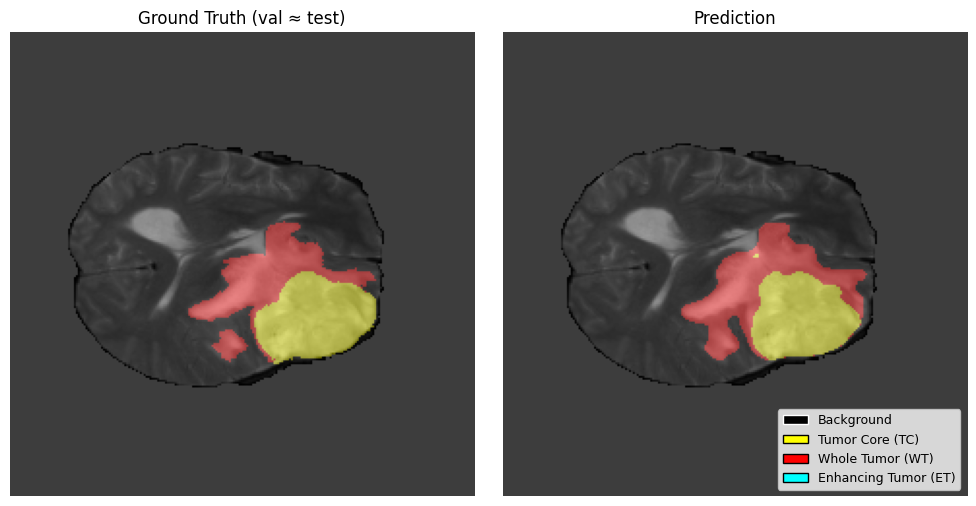

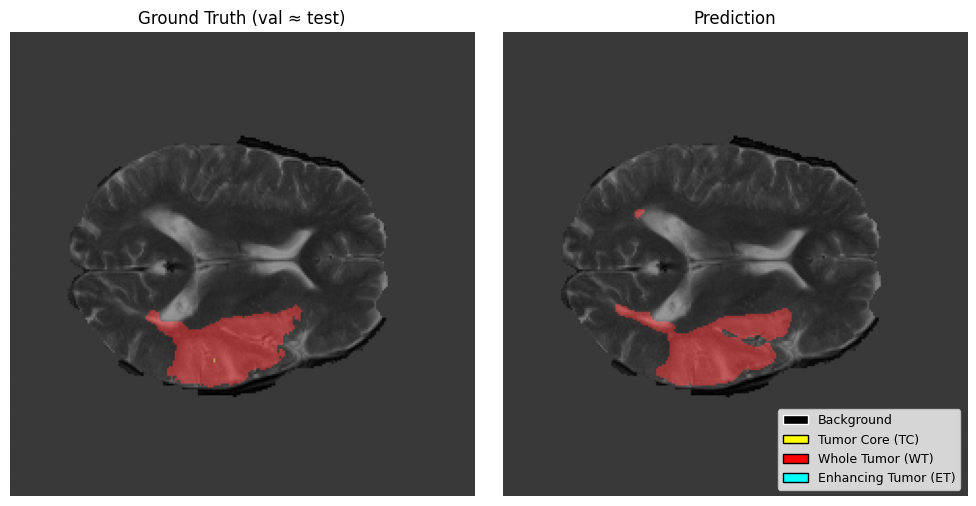

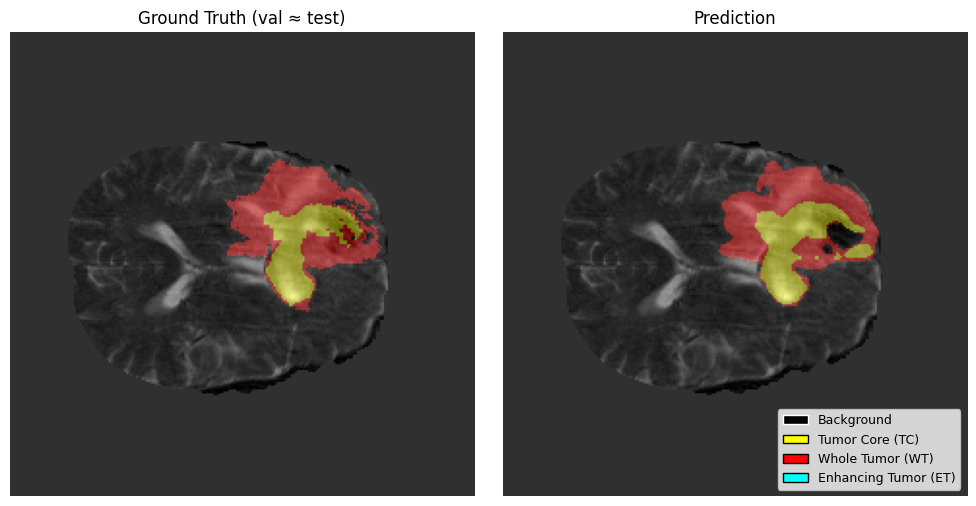

In [28]:
# === Test(=Validation) data で予測 vs 正解のカラーマップ + 凡例（legend, 英語）を表示するセル ===
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch

from monai.inferers import sliding_window_inference
from monai.data import decollate_batch

model.eval()

# いくつかの症例を表示
num_cases_to_show = 3       # 表示したい症例数
slice_mode = "center"       # "center" なら中央スライス、"random" ならランダムスライス

# ラベル3ch( TC / WT / ET ) を 1枚のラベルマップ(0〜3)にまとめる関数
def one_hot_3ch_to_label_map(mask_3ch: np.ndarray) -> np.ndarray:
    """
    mask_3ch: (3, H, W) の 0/1 マップ (TC, WT, ET)
    return: (H, W) 0: background, 1: TC, 2: WT, 3: ET
    """
    stacked = mask_3ch  # (3, H, W)
    max_val = np.max(stacked, axis=0)            # (H, W)
    label_map = np.argmax(stacked, axis=0) + 1   # 1〜3

    # all zero -> background
    label_map[max_val == 0] = 0
    return label_map.astype(np.int16)

# カラーマップ定義
# 0: black (BG), 1: yellow (TC), 2: red (WT), 3: cyan (ET)
cmap = ListedColormap(["black", "yellow", "red", "cyan"])
norm = BoundaryNorm([0, 0.5, 1.5, 2.5, 3.5], cmap.N)

# 凡例用パッチ（英語表記に変更）
legend_patches = [
    Patch(facecolor="black", edgecolor="white", label="Background"),
    Patch(facecolor="yellow", edgecolor="black", label="Tumor Core (TC)"),
    Patch(facecolor="red", edgecolor="black", label="Whole Tumor (WT)"),
    Patch(facecolor="cyan", edgecolor="black", label="Enhancing Tumor (ET)"),
]

cases_shown = 0

with torch.inference_mode():
    for batch_data in val_loader:  # ★ test_loader があれば test_loader に変更
        images = batch_data["image"].to(device)
        labels = batch_data["label"].cpu()

        # 形状: images = (B=1, C=4, H, W, D)
        preds = sliding_window_inference(
            images,
            roi_size=config.inference_roi_size,
            sw_batch_size=config.sw_batch_size,
            predictor=model,
            overlap=config.sw_overlap,
        )

        # B=1 前提で 0 番目だけ取り出し、post_trans で sigmoid + threshold
        preds_list = [post_trans(p) for p in decollate_batch(preds)]
        pred_mask = preds_list[0].cpu().numpy()   # (3, H, W, D)
        gt_mask = labels[0].numpy()               # (3, H, W, D)

        img_np = images[0].detach().cpu().numpy() # (C=4, H, W, D)

        # 表示するスライス index を決定 (D がスライス方向)
        num_slices = img_np.shape[-1]
        if slice_mode == "random":
            slice_idx = np.random.randint(num_slices)
        else:  # "center"
            slice_idx = num_slices // 2

        # FLAIR (C=3) をベース画像として使う（なければ最後のch）
        if img_np.shape[0] >= 4:
            base_img = img_np[3, :, :, slice_idx]  # FLAIR
        else:
            base_img = img_np[-1, :, :, slice_idx]  # last channel

        # GT / Prediction を 3ch -> 1枚のラベルマップへ
        gt_slice_3ch = gt_mask[:, :, :, slice_idx]       # (3, H, W)
        pred_slice_3ch = pred_mask[:, :, :, slice_idx]   # (3, H, W)

        gt_label_map = one_hot_3ch_to_label_map(gt_slice_3ch)
        pred_label_map = one_hot_3ch_to_label_map(pred_slice_3ch)

        # 描画
        fig, axes = plt.subplots(1, 2, figsize=(10, 5))

        # 左: Ground Truth
        axes[0].imshow(base_img, cmap="gray")
        axes[0].imshow(gt_label_map, cmap=cmap, norm=norm, alpha=0.4)
        axes[0].set_title("Ground Truth (val ≈ test)")
        axes[0].axis("off")

        # 右: Prediction
        axes[1].imshow(base_img, cmap="gray")
        axes[1].imshow(pred_label_map, cmap=cmap, norm=norm, alpha=0.4)
        axes[1].set_title("Prediction")
        axes[1].axis("off")

        # 凡例（legend）を右側のサブプロット内に表示
        axes[1].legend(
            handles=legend_patches,
            loc="lower right",
            framealpha=0.8,
            fontsize=9,
        )

        plt.tight_layout()
        plt.show()

        cases_shown += 1
        if cases_shown >= num_cases_to_show:
            break

You can also check out the report [Brain Tumor Segmentation using MONAI and WandB](https://wandb.ai/geekyrakshit/brain-tumor-segmentation/reports/Brain-Tumor-Segmentation-using-MONAI-and-WandB---Vmlldzo0MjUzODIw) for more details regarding training a brain-tumor segmentation model using MONAI and W&B.